### Preprocesado de los datos

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

#### Variables exógenas

**Temperatura:** Se ha descargado los valores de temperaturas máximas y mínimas de la AEMET parseando el código de la web "datosclima.es"

In [12]:
def load_temps(fname: str = "exo/temps.html") -> pd.DataFrame:
    """ Carga las temperaturas diarias del HTML"""
    tabs = pd.read_html(Path(fname))
    tabs = [tabs[i] for i in [3,4,5,7,8,9,11,12,13]]  
    for t in tabs:
        t.columns = ["date", "tmax", "tmin"]
        t.drop(index=[0], inplace=True)
    temps = pd.concat(tabs, ignore_index=True)
    temps["date"] = pd.to_datetime(temps["date"], format="%d-%m-%Y")
    temps[["tmax", "tmin"]] = temps[["tmax", "tmin"]].astype(float)
    temps.interpolate(method="pad", inplace=True)
    return temps

**Festivos:** Se ha descargado los festivos locales y nacionales del dataset ["Fiestas locales y autonómicas del Principado de Asturias "](https://datos.gob.es/es/catalogo/a03002951-fiestas-locales-autonomicas-principado-asturias") del portal de datos público "datos.gob.es".

In [13]:
def load_fest() -> pd.DataFrame:
    """ Carga los festivos de los ficheros csv"""
    fest = []
    for y in [21, 22, 23]:
        dfy = pd.read_csv(f"exo/festivos_{y}.csv")
        dfy.columns = ["tipo", "lugar", "date", "fiesta"]
        fest.append(dfy)
    fest = pd.concat(fest, ignore_index=True)
    fest = fest[(fest["tipo"] == "AUTONOMICO") | (fest["lugar"] == "GIJÓN") | (fest["lugar"] == "VILLAVICIOSA")]
    fest["date"] = pd.to_datetime(fest["date"], format="%m/%d/%Y")
    fest.sort_values("date", inplace=True)
    fest.reset_index(inplace=True, drop=True)
    return fest


#### Datos de entrenamiento / predicción

In [14]:
municipios = {
    "gijon": "GIJÓN",
    "peon": "VILLAVICIOSA"
}

def load_train_data(place: str = "gijon") -> pd.DataFrame:

    # load csv files
    df = pd.read_csv(f"datasets/2021_2023_{place}_train.csv")

    df.columns = ["ts", "cons"]
    df["ts"] = pd.to_datetime(df["ts"])
    df["date"] = df["ts"].dt.date
    df["place"] = place

    # add temperatures
    temp = load_temps()
    temp["date"] = temp["date"].dt.date
    df = pd.merge(df, temp, left_on="date", right_on="date", how="left")
    df.sort_values(["place", "date"], inplace=True)
    df[["tmax","tmin"]] = df[["tmax","tmin"]].interpolate(method="linear")

    # load and assign festives
    fest = load_fest()
    df["festivo"] = df["date"].isin(fest[(fest["tipo"] == "AUTONOMICO") | (fest["lugar"] == municipios[place])]["date"].dt.date)

    # join both and reorder cols
    df = df[["cons", "tmax","tmin", "ts", "place","date","festivo"]]

    # add variables for workdays
    df["finde"] = df["ts"].dt.weekday.isin([5,6])
    df["laboral"] = ~(df["finde"] | df["festivo"])

    df["hour"] = df["ts"].dt.hour
    df["horario_laboral"] = df["hour"].isin([6,7,8,9,10,11,12,13,14,15,16,17,18]) # de 7 a 19

    # create dummy vars for hour weekday and month 
    df["dow"] = df["ts"].dt.day_of_week   
    df["doy"] = df["ts"].dt.day_of_year
    
    # grab min, max, mean values
    df["max_daily_cons"] = df["doy"].replace(df.groupby(["doy"])["cons"].max())
    df["avg_daily_cons"] = df["doy"].replace(df.groupby(["doy"])["cons"].mean())
    df["min_daily_cons"] = df["doy"].replace(df.groupby(["doy"])["cons"].min())

    # set index frequency
    df.set_index(df["ts"], inplace=True, drop=True)
    df = df.asfreq("H",method="pad")
    df.index.name = None
    
    # drop unused columns and assign correct dtypes
    df.drop(columns=["ts", "date", "place", "doy"], inplace=True)
    # for c in ["laboral", "finde", "festivo", "horario_laboral"]:
    #     df[c] = df[c].astype(int)

    # fix 0 values (shorcuts?)
    df.loc[df["cons"] == 0, "cons"] = np.NAN

    # return the data
    return df


def load_pred_data(start: np.datetime64, nhours: int, place: str = "gijon") -> pd.DataFrame:

    """ Prepares the input data for the predictions. """

    df = pd.DataFrame(index=pd.date_range(start=start, periods=nhours, freq="H"))
    df.index: pd.DatetimeIndex
    df["date"] = df.index.date
    df["place"] = place

    # add temperatures
    temp = load_temps()
    temp["date"] = temp["date"].dt.date
    df = pd.merge(df, temp, left_on="date", right_on="date", how="left")
    df.set_index(pd.date_range(start=start, periods=nhours, freq="H"), inplace=True, drop=True)
    
    df.sort_values(["place", "date"], inplace=True)

    df[["tmax","tmin"]] = df[["tmax","tmin"]].interpolate()

    # load and assign festives
    fest = load_fest()
    df["festivo"] = df["date"].isin(fest[(fest["tipo"] == "AUTONOMICO") | (fest["lugar"] == municipios[place])]["date"].dt.date)

    # join both and reorder cols
    df = df[["tmax","tmin", "place","date","festivo"]]

    # add variables for workdays
    df["finde"] = df.index.weekday.isin([5,6])
    df["laboral"] = ~(df["finde"] | df["festivo"])

    # add variables for work hours
    df["hour"] = df.index.hour
    df["horario_laboral"] = df["hour"].isin([6,7,8,9,10,11,12,13,14,15,16,17,18]) # de 7 a 19

    # create dummy vars for dayofweek and dayofyear
    df["dow"] = df.index.day_of_week
    #df["month"] = df["ts"].dt.month
    df["doy"] = df.index.day_of_year

    # read cons data to get daily averages
    dfdat = pd.read_csv(f"datasets/2021_2023_{place}_train.csv")
    dfdat.columns = ["ts", "cons"]
    dfdat["ts"] = pd.to_datetime(dfdat["ts"])
    dfdat["doy"] = dfdat["ts"].dt.day_of_year
    
    # grab min, max, mean values
    df["max_daily_cons"] = df["doy"].replace(dfdat.groupby("doy")["cons"].max())
    df["avg_daily_cons"] = df["doy"].replace(dfdat.groupby(["doy"])["cons"].mean())
    df["min_daily_cons"] = df["doy"].replace(dfdat.groupby("doy")["cons"].min())

    # drop unused columns and assign correct dtypes
    df.drop(columns=["date", "place", "doy"], inplace=True)
    for c in ["laboral", "finde", "festivo", "horario_laboral"]:
        df[c] = df[c].astype(int)

    return df

#### Optimización de los datos

In [15]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Entrenamiento de Modelos

In [53]:
target = "cons" # objetivo de la predicción
place = "gijon" # "gijon" / "peon"
forecast_horizon = 24*30*2 # 2 meses, en horas

# generate the data
df_train = load_train_data(place=place)
df_pred = load_pred_data(place=place, start=np.datetime64('2023-04-27T01:00'), nhours=forecast_horizon)

# optimize the data
df_train = reduce_mem_usage(df_train)
df_pred = reduce_mem_usage(df_pred)

/tmp/ipykernel_453116/472041089.py:11: FutureWarning:

DataFrame.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/tmp/ipykernel_453116/472041089.py:11: FutureWarning:

DataFrame.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Memory usage of dataframe is 0.92 MB
Memory usage after optimization is: 0.43 MB
Decreased by 53.3%
Memory usage of dataframe is 0.11 MB
Memory usage after optimization is: 0.03 MB
Decreased by 72.5%


In [54]:
df_train

,cons,tmax,tmin,festivo,finde,laboral,hour,horario_laboral,dow,max_daily_cons,avg_daily_cons,min_daily_cons
2021-06-26 01:00:00,26.0,19.000000,16.406250,0.0,1.0,0.0,1,0.0,5,31,25.953125,23
2021-06-26 02:00:00,26.0,19.000000,16.406250,0.0,1.0,0.0,2,0.0,5,31,25.953125,23
2021-06-26 03:00:00,27.0,19.000000,16.406250,0.0,1.0,0.0,3,0.0,5,31,25.953125,23
2021-06-26 04:00:00,26.0,19.000000,16.406250,0.0,1.0,0.0,4,0.0,5,31,25.953125,23
2021-06-26 05:00:00,27.0,19.000000,16.406250,0.0,1.0,0.0,5,0.0,5,31,25.953125,23
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-26 20:00:00,27.0,22.906250,15.500000,0.0,0.0,1.0,20,0.0,2,66,41.562500,23
2023-04-26 21:00:00,27.0,22.906250,15.500000,0.0,0.0,1.0,21,0.0,2,66,41.562500,23
2023-04-26 22:00:00,26.0,22.906250,15.500000,0.0,0.0,1.0,22,0.0,2,66,41.562500,23
2023-04-26 23:00:00,27.0,22.906250,15.500000,0.0,0.0,1.0,23,0.0,2,66,41.562500,23


In [55]:
df_pred

,tmax,tmin,festivo,finde,laboral,hour,horario_laboral,dow,max_daily_cons,avg_daily_cons,min_daily_cons
2023-04-27 01:00:00,22.703125,14.296875,0,0,1,1,0,3,61,39.906250,27
2023-04-27 02:00:00,22.703125,14.296875,0,0,1,2,0,3,61,39.906250,27
2023-04-27 03:00:00,22.703125,14.296875,0,0,1,3,0,3,61,39.906250,27
2023-04-27 04:00:00,22.703125,14.296875,0,0,1,4,0,3,61,39.906250,27
2023-04-27 05:00:00,22.703125,14.296875,0,0,1,5,0,3,61,39.906250,27
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-25 20:00:00,24.000000,19.093750,0,1,0,20,0,6,28,25.171875,24
2023-06-25 21:00:00,24.000000,19.093750,0,1,0,21,0,6,28,25.171875,24
2023-06-25 22:00:00,24.000000,19.093750,0,1,0,22,0,6,28,25.171875,24
2023-06-25 23:00:00,24.000000,19.093750,0,1,0,23,0,6,28,25.171875,24


In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import KFold
import lightgbm as lgb
import numpy as np
import optuna

df_train.dropna(inplace=True)
X = df_train.drop("cons", axis=1).values
y = df_train[["cons"]].values
n_splits = 5

def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000, log=True),
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)
    }
    kf = KFold(n_splits=n_splits)
    rmse, mape, r2 = np.zeros(n_splits), np.zeros(n_splits), np.zeros(n_splits)
    for i, (train, test) in enumerate(kf.split(np.arange(X.shape[0]))):
        X_train, X_val, y_train, y_val = X[train], X[test], y[train], y[test]
        model = lgb.LGBMRegressor(**params)
        model.fit(X_train, np.squeeze(y_train))
        predictions = model.predict(X_val)
        rmse[i] = mean_squared_error(np.squeeze(y_val), predictions, squared=False)
        mape[i] = mean_absolute_percentage_error(np.squeeze(y_val), predictions)
        r2[i] = r2_score(np.squeeze(y_val), predictions)
 
    return rmse.mean(), mape.mean(), r2.mean()

In [57]:
study = optuna.create_study(
    storage="sqlite:///optuna-database.sqlite3",
    study_name=f"lgbm-{place}",
    load_if_exists=True,
    directions=['minimize','minimize', 'maximize'])
#study.optimize(objective, n_trials=100)

[I 2023-11-21 20:12:50,496] Using an existing study with name 'lgbm-gijon' instead of creating a new one.


In [58]:
optuna.visualization.plot_pareto_front(study, target_names=["RMSE", "MAPE", "R2"])

In [62]:
tgt_stat = 0 # [RMSE, MAPE, R2]
trial = max(study.best_trials, key=lambda t: t.values[tgt_stat])
print('Best hyperparameters:', trial.params)
print('Best [RMSE, MAPE, R2]:', trial.values)

Best hyperparameters: {'n_estimators': 318, 'learning_rate': 0.012525877577601145, 'num_leaves': 114, 'subsample': 0.3488305512774496, 'colsample_bytree': 0.9959462337762435, 'min_data_in_leaf': 89}
Best [RMSE, MAPE, R2]: [5.306669662970827, 0.09615054001575007, 0.8735736532486407]


In [63]:
import lightgbm as lgb

params = {"objective": "regression", "metric": "rmse",
        "n_estimators": trial.params['n_estimators'],
        "verbosity": -1, "bagging_freq": 1,
        "learning_rate": trial.params['learning_rate'],
        "num_leaves": trial.params['num_leaves'],
        "subsample": trial.params['subsample'],
        "colsample_bytree": trial.params['colsample_bytree'],
        "min_data_in_leaf": trial.params['min_data_in_leaf']}

model = lgb.LGBMRegressor(**params)
model.fit(X, np.squeeze(y))

LGBMRegressor(bagging_freq=1, colsample_bytree=0.9959462337762435,
              learning_rate=0.012525877577601145, metric='rmse',
              min_data_in_leaf=89, n_estimators=318, num_leaves=114,
              objective='regression', subsample=0.3488305512774496,
              verbosity=-1)

In [64]:
model.booster_.save_model(f"model_weights-{place}.txt");

In [65]:
preds = pd.DataFrame(index=df_pred.index, data=model.predict(df_pred.values), columns=["cons"])
preds

,cons
2023-04-27 01:00:00,27.535782
2023-04-27 02:00:00,27.507529
2023-04-27 03:00:00,27.490708
2023-04-27 04:00:00,27.488944
2023-04-27 05:00:00,27.553155
...,...
2023-06-25 20:00:00,25.513335
2023-06-25 21:00:00,25.527072
2023-06-25 22:00:00,25.276188
2023-06-25 23:00:00,25.248207


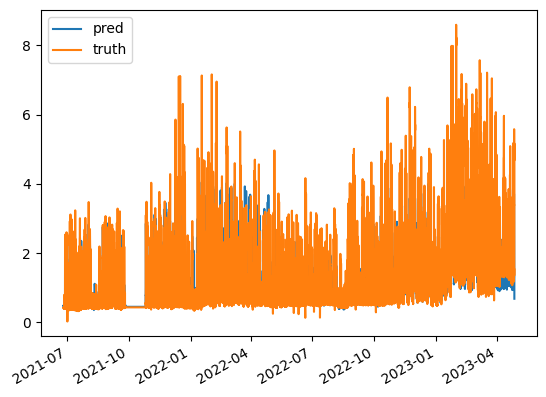

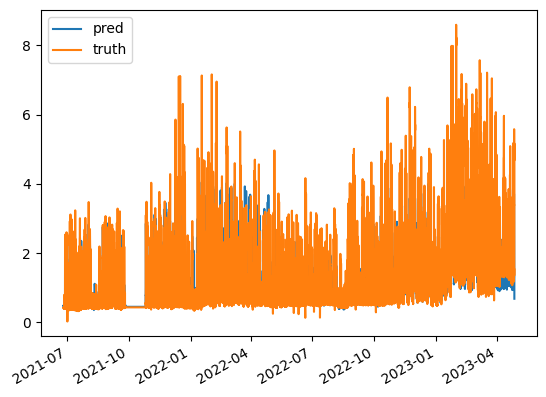

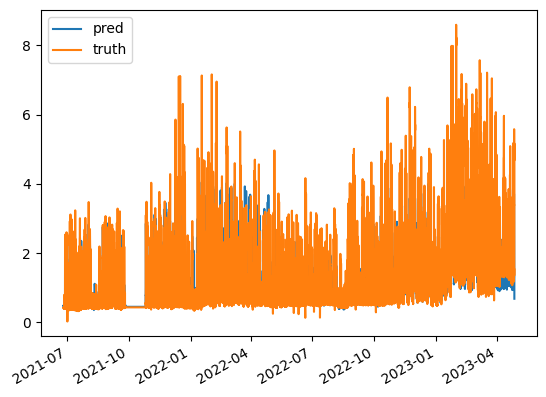

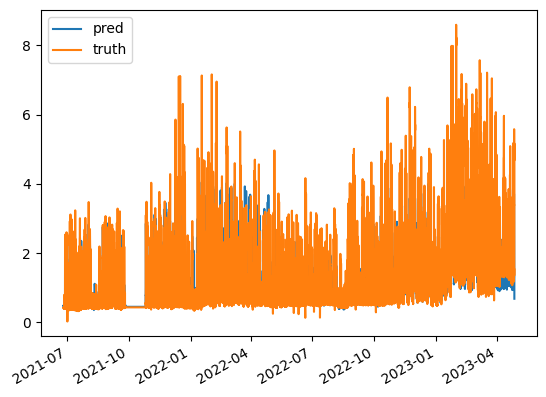

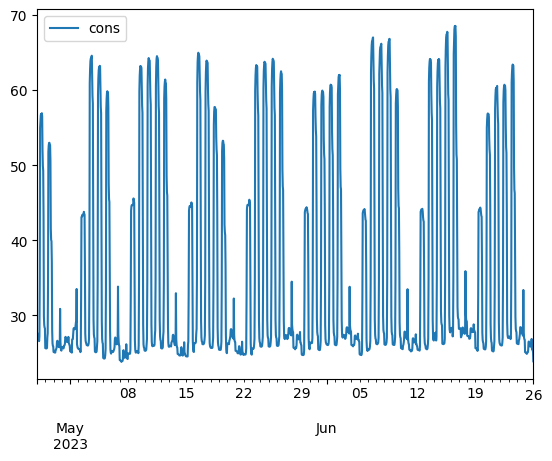

In [66]:
%matplotlib inline
preds.plot();

Baseline RMSE: 5.934
Baseline MAPE: 0.0782
Baseline R2: 0.8523986064667833
RMSE: 3.795291292562366
MAPE: 0.06834151302142687
MAPE: 0.9396100418466414


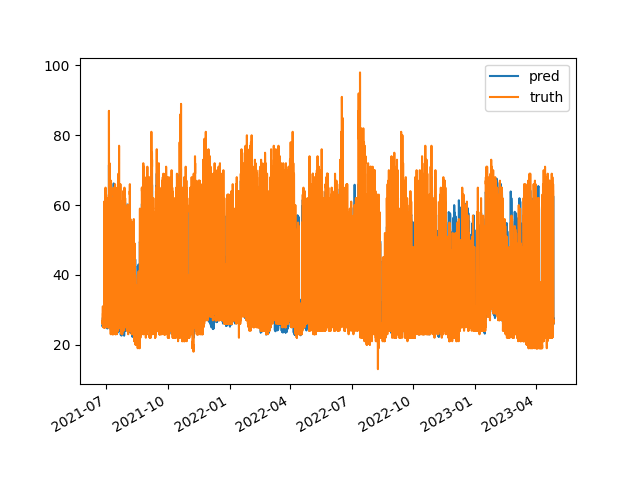

In [67]:
%matplotlib widget
inpreds = pd.DataFrame(index=df_train.index, data=model.predict(X), columns=["pred"])
inpreds["truth"] = df_train["cons"]
inpreds[["pred", "truth"]].plot()
print("Baseline RMSE:", mean_squared_error(inpreds["truth"].iloc[:-1], inpreds["truth"].shift(-1).iloc[:-1], squared=False))
print("Baseline MAPE:", mean_absolute_percentage_error(inpreds["truth"].iloc[:-1], inpreds["truth"].shift(-1).iloc[:-1]))
print("Baseline R2:",r2_score(inpreds["truth"].iloc[:-1], inpreds["truth"].shift(-1).iloc[:-1]))
print("RMSE:", mean_squared_error(inpreds["truth"], inpreds["pred"], squared=False))
print("MAPE:", mean_absolute_percentage_error(inpreds["truth"], inpreds["pred"]))
print("R2:", r2_score(inpreds["truth"], inpreds["pred"]))

In [30]:
%matplotlib inline
inpreds["dif"] = inpreds["pred"] - inpreds["truth"]
inpreds["dif"].plot()

<Axes: >